# BANKS

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import OrderedDict
import datetime
import glob
#import ipywidgets as widgets
from IPython.display import display, Markdown, HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import coint, adfuller
import sys
from typing import Dict, List

p = os.path.abspath('../../tradelib')
if p not in sys.path:
    sys.path.insert(0, p)

from tradelib.dataset import config, StockSummary, IndexSummary
import tradelib.pipeline as P
import tradelib.plotting as pt

register_matplotlib_converters()
    
MILLION = 1000000
BILLION = 1000 * MILLION


In [3]:
TICKER_LKTYPES = ['BBRI-induk', 'BMRI']

In [4]:
def read_monthly(ticker_lktype: str) -> pd.DataFrame:
    tokens = ticker_lktype.split('-')
    ticker = tokens[0]
    lktype = tokens[1] if len(tokens)>1 else ''
    
    monthly = pd.read_excel(f'{ticker}/{ticker_lktype}.xlsx', parse_dates=['date'])
    monthly.insert(0, 'ticker_lktype', ticker_lktype)
    #monthly['date'] = monthly['date'] + pd.Timedelta(days=1)
    monthly = monthly.set_index(['ticker_lktype', 'date'], drop=True)
    
    # Convert income statement columns to monthly
    pos = monthly.columns.get_loc('pendapatan bunga')
    income_columns = monthly.columns[pos:]
    monthly[income_columns] = monthly[income_columns].astype(float)
    for i in range(len(monthly)-1, 0, -1):
        if monthly.index[i][1].month > 1:
            monthly.loc[monthly.index[i], income_columns] -= monthly.loc[monthly.index[i-1], income_columns]

    if monthly.index[0][1].month > 1:
        monthly = monthly.iloc[1:]

    # Convert to milyar
    pos = monthly.columns.get_loc('pembulatan')
    pembulatan = monthly.iloc[0, pos]
    value_cols = monthly.columns[pos:]
    monthly[value_cols] *= (pembulatan / 1e9)
    monthly = monthly.drop(columns=['pembulatan'])
    
    # calculate tahunan (rolling 12 month)
    monthly['kredit avg'] = monthly['kredit'].rolling(12).mean()
    for col in income_columns:
        monthly[col + ' ttm'] = monthly[col].rolling(12).sum()
    return monthly


def read_monthlies():
    dfs = []
    for ticker in TICKER_LKTYPES:
        df = read_monthly(ticker)
        dfs.append(df)
    return pd.concat(dfs)

In [5]:
master = read_monthlies()
master.columns

Index(['kredit', 'cadangan kerugian kredit', 'kol1', 'kol2', 'kol3', 'kol4',
       'kol5', 'giro', 'tabungan', 'deposito', 'e-money', 'debt', 'liabilitas',
       'ekuitas', 'pendapatan bunga', 'beban bunga', 'pendapatan bersih',
       'pendapatan premi bersih', 'beban nilai aset keuangan',
       'beban nilai liabilitas keuangan',
       'beban nilai penjualan aset keuangan',
       'beban nilai transaksi spot derivatif', 'beban nilai penyertaan equity',
       'beban nilai valas', 'pendapatan dividen', 'pendapatan komisi',
       'pendapatan lainnya', 'beban impairment', 'beban risiko operasional',
       'beban tenaga kerja', 'beban promosi', 'beban lainnya',
       'total pendapatan beban operasional', 'laba operasional',
       'laba sebelum pajak', 'laba bersih', 'laba komprehensif', 'kredit avg',
       'pendapatan bunga ttm', 'beban bunga ttm', 'pendapatan bersih ttm',
       'pendapatan premi bersih ttm', 'beban nilai aset keuangan ttm',
       'beban nilai liabilitas keuang

## Plots

In [15]:
def plot_everything(ticker_lktypes: List[str], normalize=True):
    start_date = pd.Timestamp('2022-12-31').date()
    columns = []
    tickers = ticker_lktypes
    
    display(Markdown(f'### {", ".join(ticker_lktypes)}'))
    
    for ticker in tickers:
        df = master.loc[ticker].copy()
        df = df.loc[start_date:,:]
        
        # kredit disalurkan
        kredit = df['kredit'].rename(f'{ticker} kredit disalurkan')
        columns.append((kredit / kredit.iloc[0]) if normalize else kredit)
        
        # total CKPN
        ckpn = df['cadangan kerugian kredit'].rename(f'{ticker} total CKPN')
        columns.append((ckpn / ckpn.iloc[0]) if normalize else ckpn)

        # rasio CKPN
        rasio_ckpn = (df['cadangan kerugian kredit'] / df['kredit']).rename(f'{ticker} rasio CKPN')
        columns.append(rasio_ckpn)
        
        # kol 2-5
        kol25 = df[['kol2', 'kol3', 'kol4', 'kol5']].sum(axis=1).rename(f'{ticker} Kol 2-5')
        kol25 = kol25.replace(0, np.NaN).fillna(method='pad')
        columns.append((kol25/kol25.iloc[0]) if normalize else kol25)
        
        # NPL gross
        npl_gross = (kol25/kredit).rename(f'{ticker} NPL Gross')
        columns.append(npl_gross)
        
        # kol 3-5
        kol35 = df[['kol3', 'kol4', 'kol5']].sum(axis=1).rename(f'{ticker} Kol 3-5')
        kol35 = kol35.replace(0, np.NaN).fillna(method='pad')
        columns.append((kol35/kol35.iloc[0]) if normalize else kol35)
        
        # NPL net
        npl_net = (kol35/kredit).rename(f'{ticker} NPL Net')
        columns.append(npl_net)
        
        # Rasio CKPN thd kol 2-5
        ckpn_to_kol25 = (ckpn/kol25).rename(f'{ticker} rasio ckpn/kol25')
        columns.append(ckpn_to_kol25)
        
        # Rasio CKPN thd kol 3-5
        ckpn_to_kol35 = (ckpn/kol35).rename(f'{ticker} rasio ckpn/kol35')
        columns.append(ckpn_to_kol35)
        
        # dana simpanan
        simpanan = df[['giro', 'tabungan', 'deposito', 'e-money']].sum(axis=1).rename(f'{ticker} dana simpanan')
        columns.append((simpanan/simpanan.iloc[0]) if normalize else simpanan)

        # CASA
        casa = df[['giro', 'tabungan', 'e-money']].sum(axis=1).rename(f'{ticker} CASA')
        columns.append((casa/casa.iloc[0]) if normalize else casa)
        
        # CASA ratio
        casa_ratio = (casa/simpanan).rename(f'{ticker} Rasio CASA')
        columns.append(casa_ratio)
        
        # LDR
        ldr = (kredit / simpanan).rename(f'{ticker} LDR')
        columns.append(ldr)
        
        # Pendapatan bunga
        rev_b = df['pendapatan bunga'].rename(f'{ticker} pendapatan bunga bulanan')
        columns.append((rev_b/rev_b.iloc[0]) if normalize else rev_b)

        rev_ttm = df['pendapatan bunga ttm'].rename(f'{ticker} pendapatan bunga ttm')
        columns.append((rev_ttm/rev_ttm.iloc[0]) if normalize else rev_ttm)
        
        beban_bunga_b = df['beban bunga'].rename(f'{ticker} beban bunga bulanan')
        columns.append((beban_bunga_b/beban_bunga_b.iloc[0]) if normalize else beban_bunga_b)
        
        beban_bunga_ttm = df['beban bunga ttm'].rename(f'{ticker} beban bunga ttm')
        columns.append((beban_bunga_ttm/beban_bunga_ttm.iloc[0]) if normalize else beban_bunga_ttm)
        
        # GPM
        gpm_b = (df['pendapatan bersih']/rev_b).rename(f'{ticker} GPM bulanan')
        columns.append(gpm_b)

        gpm_ttm = (df['pendapatan bersih ttm']/rev_ttm).rename(f'{ticker} GPM ttm')
        columns.append(gpm_ttm)
        
        # NIM ttm
        nim_ttm = (df['pendapatan bersih ttm']/df['kredit avg']).rename(f'{ticker} NIM ttm')
        columns.append(nim_ttm)
        
        # NIM bulanan annualized
        nim_b_ann = (df['pendapatan bersih']*12/df['kredit']).rename(f'{ticker} NIM bulanan annz')
        columns.append(nim_b_ann)
        
        # beban impairment
        beban_impairment_b = df['beban impairment'].rename(f'{ticker} beban impairment bulanan')
        columns.append((beban_impairment_b/beban_impairment_b.iloc[0]) if normalize else beban_impairment_b)

        beban_impairment_ttm = df['beban impairment ttm'].rename(f'{ticker} beban impairment ttm')
        columns.append((beban_impairment_ttm/beban_impairment_ttm.iloc[0]) if normalize else beban_impairment_ttm)

        rasio_ckpn_thd_pend_b = (beban_impairment_b / rev_b).rename(f'{ticker} rasio bbn ckpn bulanan')
        columns.append(rasio_ckpn_thd_pend_b)

        rasio_ckpn_thd_pend_ttm = (beban_impairment_ttm / rev_ttm).rename(f'{ticker} rasio bbn ckpn ttm')
        columns.append(rasio_ckpn_thd_pend_ttm)
        
        
        # Laba operasional
        laba_opr_b = df['laba operasional'].rename(f'{ticker} laba operasional bulanan')
        columns.append((laba_opr_b/laba_opr_b.iloc[0]) if normalize else laba_opr_b)

        laba_opr_ttm = df['laba operasional ttm'].rename(f'{ticker} laba operasional ttm')
        columns.append((laba_opr_ttm/laba_opr_ttm.iloc[0]) if normalize else laba_opr_ttm)
        
        # OPM
        opm_b = (laba_opr_b/rev_b).rename(f'{ticker} OPM bulanan')
        columns.append(opm_b)

        opm_ttm = (laba_opr_ttm/rev_ttm).rename(f'{ticker} OPM ttm')
        columns.append(opm_ttm)
        
        # PPOP
        ppop_b = (laba_opr_b + beban_impairment_b).rename(f'{ticker} PPOP bulanan')
        columns.append((ppop_b/ppop_b.iloc[0]) if normalize else ppop_b)
        
        ppop_ttm = (laba_opr_ttm + beban_impairment_ttm).rename(f'{ticker} PPOP ttm')
        columns.append((ppop_ttm/ppop_ttm.iloc[0]) if normalize else ppop_ttm)

        ppop_margin_b = (ppop_b / rev_b).rename(f'{ticker} PPOP margin bulanan')
        columns.append(ppop_margin_b)
        
        ppop_margin_ttm = (ppop_ttm / rev_ttm).rename(f'{ticker} PPOP margin ttm')
        columns.append(ppop_margin_ttm)
        
        # Laba sbl pajak
        ebt_b = df['laba sebelum pajak'].rename(f'{ticker} ebit bulanan')
        columns.append((ebt_b/ebt_b.iloc[0]) if normalize else ebt_b)
        
        # EBT ratio
        ebitm_b = (ebt_b/rev_b).rename(f'{ticker} margin ebit bulanan')
        columns.append(ebitm_b)
        
        # Laba bersih
        laba_bersih_b = df['laba bersih'].rename(f'{ticker} laba bersih bulanan')
        columns.append((laba_bersih_b/laba_bersih_b.iloc[0]) if normalize else laba_bersih_b)

        laba_bersih_ttm = df['laba bersih ttm'].rename(f'{ticker} laba bersih ttm')
        columns.append((laba_bersih_ttm/laba_bersih_ttm.iloc[0]) if normalize else laba_bersih_ttm)
        
        # NPM
        npm_b = (laba_bersih_b/rev_b).rename(f'{ticker} NPM bulanan')
        columns.append(npm_b)

        npm_ttm = (laba_bersih_ttm/rev_ttm).rename(f'{ticker} NPM ttm')
        columns.append(npm_ttm)
        
        # ROE
        roe_ttm = (laba_bersih_ttm / df['ekuitas']).rename(f'{ticker} ROE ttm')
        columns.append(roe_ttm)
        
        # ROA
        roa_ttm = (laba_bersih_ttm / (df['ekuitas'] + df['liabilitas'])).rename(f'{ticker} ROA ttm')
        columns.append(roa_ttm)
        
        
    df = pd.concat(columns, axis=1)
    ylabel = 'Milyar (Rp)' if not normalize else 'Skala Normalisasi'
    RH = 3
    LL = 'upper left'
    MK = '.'
    
    # Kredit Disalurkan, LDR, CKPN
    display(Markdown('#### Kredit Disalurkan'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} kredit disalurkan', marker=MK) for ticker in tickers], 
                 title='Kredit Disalurkan', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} total CKPN', marker=MK) for ticker in tickers], 
                 title='Total CKPN', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} LDR', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Load to Deposit Ratio', ylabel='Rasio', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} rasio CKPN', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Rasio CKPN thd Kredit', ylabel='Rasio', legend_loc=LL),
    ]
    fig = pt.Figure(charts, row_height=RH, title='Kredit Disalurkan', ncols=2)
    fig.plot(df, tight_layout=True)

    display(Markdown('''Catatan:
- LDR = kredit dibagi total simpanan
- Rasio CKPN thd Kredit = cadangan kerugian kredit di balance sheet dibagi kredit
'''))
    
    # NPL
    display(Markdown('#### Kolektibilitas, NPL, dan Coverage CKPN'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} Kol 2-5', marker=MK) for ticker in tickers], 
                 title='Total Kolektibilitas 2-5', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} Kol 3-5', marker=MK) for ticker in tickers], 
                 title='Total Kolektibilitas 3-5', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} NPL Gross', linestyle='--', marker=MK) for ticker in tickers], 
                 title='NPL Gross', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} NPL Net', linestyle='--', marker=MK) for ticker in tickers], 
                 title='NPL Net', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} rasio ckpn/kol25', linestyle='--', marker=MK) for ticker in tickers], 
                 title='CKPN Coverage thd Kol 2-5', ylabel='Rasio', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} rasio ckpn/kol35', linestyle='--', marker=MK) for ticker in tickers], 
                 title='CKPN Coverage thd Kol 3-5', ylabel='Rasio', legend_loc=LL),
    ]
    fig = pt.Figure(charts, row_height=RH, title='Kolektibilitas, NPL, CKPN', ncols=2)
    fig.plot(df, tight_layout=True)
    
    display(Markdown('''Catatan:
- Data kolektibilitas adalah untuk entitas induk (karena diambil dari lapkeu induk)
- Data kolektibilitas hanya ada di laporan kuartalan. Untuk bulanan, nilainya diteruskan dari kuartal sebelumnya
- NPL Gross = jumlah kredit kol 2-5 dibagi kredit
- NPL Net = jumlah kredit kol 3-5 dibagi kredit
- CKPN Coverage thd Kol 2-5 = CKPN di balance sheet dibagi kredit kol 2-5
- CKPN Coverage thd Kol 3-5 = CKPN di balance sheet dibagi kredit kol 3-5
'''))
    
    # Dana Simpanan
    display(Markdown('#### Dana Simpanan, CASA, dan LDR'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} dana simpanan', marker=MK) for ticker in tickers],
                 title='Total Dana Simpanan', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} CASA', marker=MK) for ticker in tickers],
                 title='CASA & E-Money', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} LDR', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Load to Deposit Ratio', ylabel='Rasio', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} Rasio CASA', linestyle='--', marker=MK) for ticker in tickers], 
                 title='CASA Ratio', ylabel='Rasio', legend_loc=LL),

    ]
    fig = pt.Figure(charts, row_height=RH, title='Dana Simpanan', ncols=2)
    fig.plot(df, tight_layout=True)
    
    display(Markdown('''Catatan:
- Rasio CASA = jumlah CASA dan e-money dibagi total dana simpanan nasabah
'''))
    
    # Pendapatan bunga
    display(Markdown('#### Pendapatan dan Beban Bunga dan GPM'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} pendapatan bunga ttm', marker=MK) for ticker in tickers],
                 title='Pendapatan Bunga TTM', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} pendapatan bunga bulanan', marker=MK) for ticker in tickers],
                 title='Pendapatan Bunga Bulanan', ylabel=ylabel, legend_loc=LL),
        
        pt.Chart([pt.Plot(f'{ticker} beban bunga ttm', marker=MK) for ticker in tickers],
                 title='Beban Bunga TTM', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} beban bunga bulanan', marker=MK) for ticker in tickers],
                 title='Beban Bunga Bulanan', ylabel=ylabel, legend_loc=LL),
        
        pt.Chart([pt.Plot(f'{ticker} GPM ttm', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Margin Pendapatan Bunga TTM', ylabel='Margin', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} GPM bulanan', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Margin Pendapatan Bunga Bulanan', ylabel='Margin', legend_loc=LL),
        
        pt.Chart([pt.Plot(f'{ticker} NIM ttm', linestyle='--', marker=MK) for ticker in tickers], 
                 title='NIM TTM', ylabel='Margin', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} NIM bulanan annz', linestyle='--', marker=MK) for ticker in tickers], 
                 title='NIM Bulanan Annualized', ylabel='Margin', legend_loc=LL),
    ]
    fig = pt.Figure(charts, row_height=RH, title='Pendapatan Bunga', ncols=2)
    fig.plot(df, tight_layout=True)
    
    display(Markdown('''Catatan:
- NIM TTM = (pendapatan bunga TTM minus beban bunga TTM) dibagi rata-rata kredit setahun terakhir
- NIM bulanan annualized = (pendapatan bunga bulanan minus beban bunga bulanan) kali 12 dibagi kredit
'''))

    # PPOP
    display(Markdown('#### PPOP'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} PPOP ttm', marker=MK) for ticker in tickers],
                 title='PPOP TTM', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} PPOP bulanan', marker=MK) for ticker in tickers],
                 title='PPOP Bulanan', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} PPOP margin ttm', linestyle='--', marker=MK) for ticker in tickers],
                 title='PPOP Margin TTM', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} PPOP margin bulanan', linestyle='--', marker=MK) for ticker in tickers],
                 title='PPOP Margin Bulanan', ylabel=ylabel, legend_loc=LL),
        
    ]
    fig = pt.Figure(charts, row_height=RH, title='Pre-Provision Operating Profit (PPOP)', ncols=2)
    fig.plot(df, tight_layout=True)

    display(Markdown('''Catatan:
- PPOP = laba operasional ditambah beban impairment
- PPOP margin = PPOP dibagi pendapatan bunga
'''))
    
    # beban CKPN
    display(Markdown('#### Beban Impairment'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} beban impairment ttm', marker=MK) for ticker in tickers],
                 title='Beban Impairment TTM', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} beban impairment bulanan', marker=MK) for ticker in tickers],
                 title='Beban Impairment Bulanan', ylabel=ylabel, legend_loc=LL),
        
        pt.Chart([pt.Plot(f'{ticker} rasio bbn ckpn ttm', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Rasio Beban Impairment thd Pendapatan Bunga TTM', ylabel='Rasio', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} rasio bbn ckpn bulanan', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Rasio Beban Impairment thd Pendapatan Bunga Bulanan', ylabel='Rasio', legend_loc=LL),

    ]
    fig = pt.Figure(charts, row_height=RH, title='Beban Impairment', ncols=2)
    fig.plot(df, tight_layout=True)

    # Operating profit
    display(Markdown('#### Operating Profit'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} laba operasional ttm', marker=MK) for ticker in tickers],
                 title='Laba Operasional TTM', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} laba operasional bulanan', marker=MK) for ticker in tickers],
                 title='Laba Operasional Bulanan', ylabel=ylabel, legend_loc=LL),
        
        pt.Chart([pt.Plot(f'{ticker} OPM ttm', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Operating Profit Margin TTM', ylabel='Rasio', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} OPM bulanan', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Operating Profit Margin Bulanan', ylabel='Rasio', legend_loc=LL),
    ]
    fig = pt.Figure(charts, row_height=RH, title='Laba Operasional', ncols=2)
    fig.plot(df, tight_layout=True)
    
    # Laba bersih
    display(Markdown('#### Laba Bersih dan NPM'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} laba bersih ttm', marker=MK) for ticker in tickers],
                 title='Laba Bersih TTM', ylabel=ylabel, legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} laba bersih bulanan', marker=MK) for ticker in tickers],
                 title='Laba Bersih Bulanan', ylabel=ylabel, legend_loc=LL),
        
        pt.Chart([pt.Plot(f'{ticker} NPM ttm', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Net Profit Margin TTM', ylabel='Rasio', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} NPM bulanan', linestyle='--', marker=MK) for ticker in tickers], 
                 title='Net Profit Margin Bulanan', ylabel='Rasio', legend_loc=LL),
    ]
    fig = pt.Figure(charts, row_height=RH, title='Laba Bersih', ncols=2)
    fig.plot(df, tight_layout=True)

    # Ratios
    display(Markdown('#### Rasio Rasio Lain'))
    charts = [
        pt.Chart([pt.Plot(f'{ticker} ROE ttm', linestyle='--', marker=MK) for ticker in tickers], 
                 title='ROE TTM', ylabel='Rasio', legend_loc=LL),
        pt.Chart([pt.Plot(f'{ticker} ROA ttm', linestyle='--', marker=MK) for ticker in tickers], 
                 title='ROA TTM', ylabel='Rasio', legend_loc=LL),
    ]
    fig = pt.Figure(charts, row_height=RH, title='Rasio-Rasio', ncols=2)
    fig.plot(df, tight_layout=True)

    return df

### BBRI-induk, BMRI

#### Kredit Disalurkan

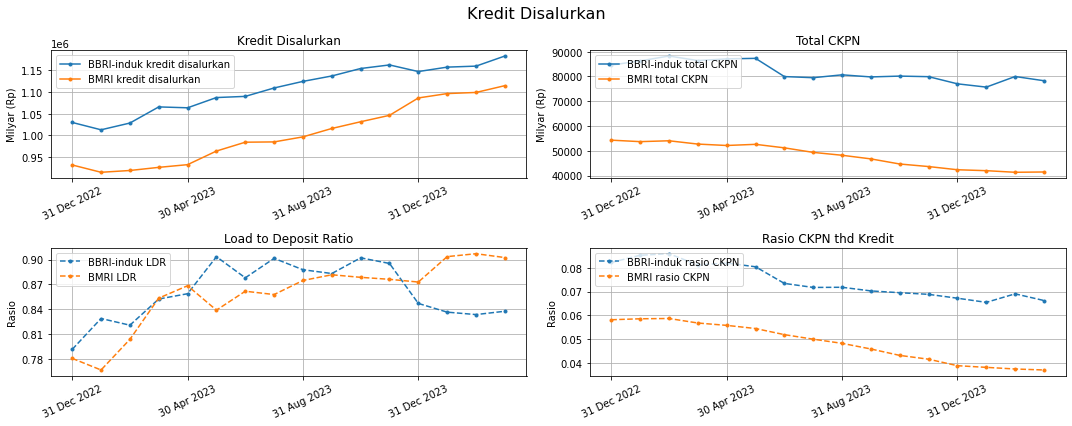

Catatan:
- LDR = kredit dibagi total simpanan
- Rasio CKPN thd Kredit = cadangan kerugian kredit di balance sheet dibagi kredit


#### Kolektibilitas, NPL, dan Coverage CKPN

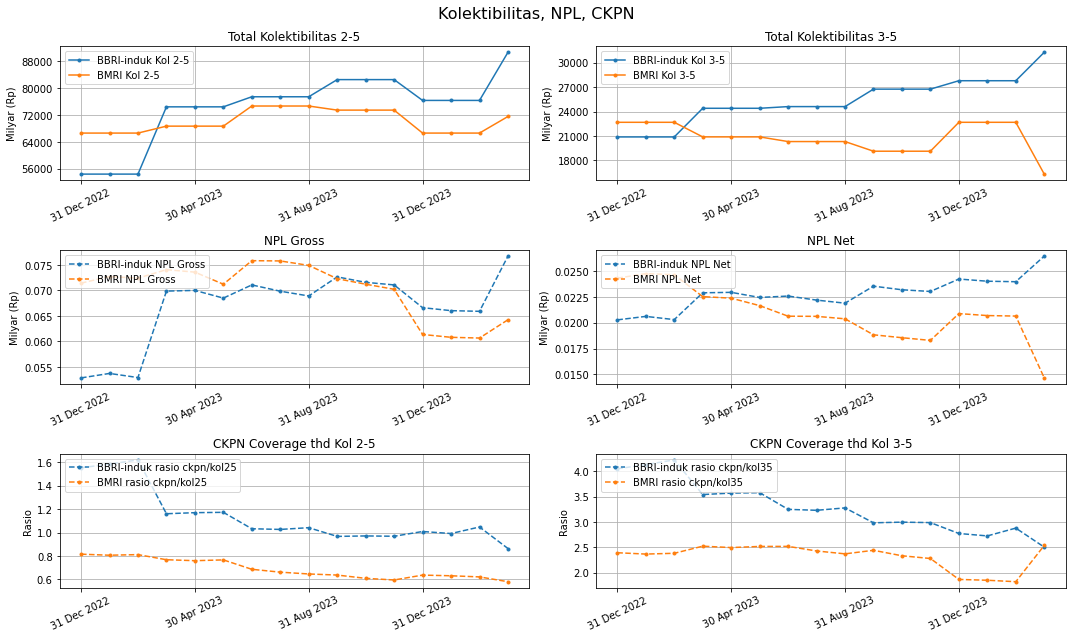

Catatan:
- Data kolektibilitas adalah untuk entitas induk (karena diambil dari lapkeu induk)
- Data kolektibilitas hanya ada di laporan kuartalan. Untuk bulanan, nilainya diteruskan dari kuartal sebelumnya
- NPL Gross = jumlah kredit kol 2-5 dibagi kredit
- NPL Net = jumlah kredit kol 3-5 dibagi kredit
- CKPN Coverage thd Kol 2-5 = CKPN di balance sheet dibagi kredit kol 2-5
- CKPN Coverage thd Kol 3-5 = CKPN di balance sheet dibagi kredit kol 3-5


#### Dana Simpanan, CASA, dan LDR

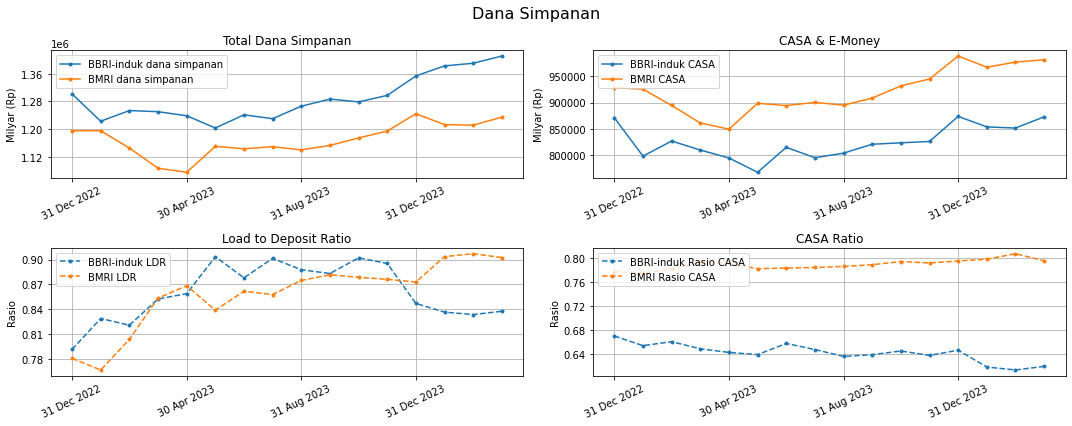

Catatan:
- Rasio CASA = jumlah CASA dan e-money dibagi total dana simpanan nasabah


#### Pendapatan dan Beban Bunga dan GPM

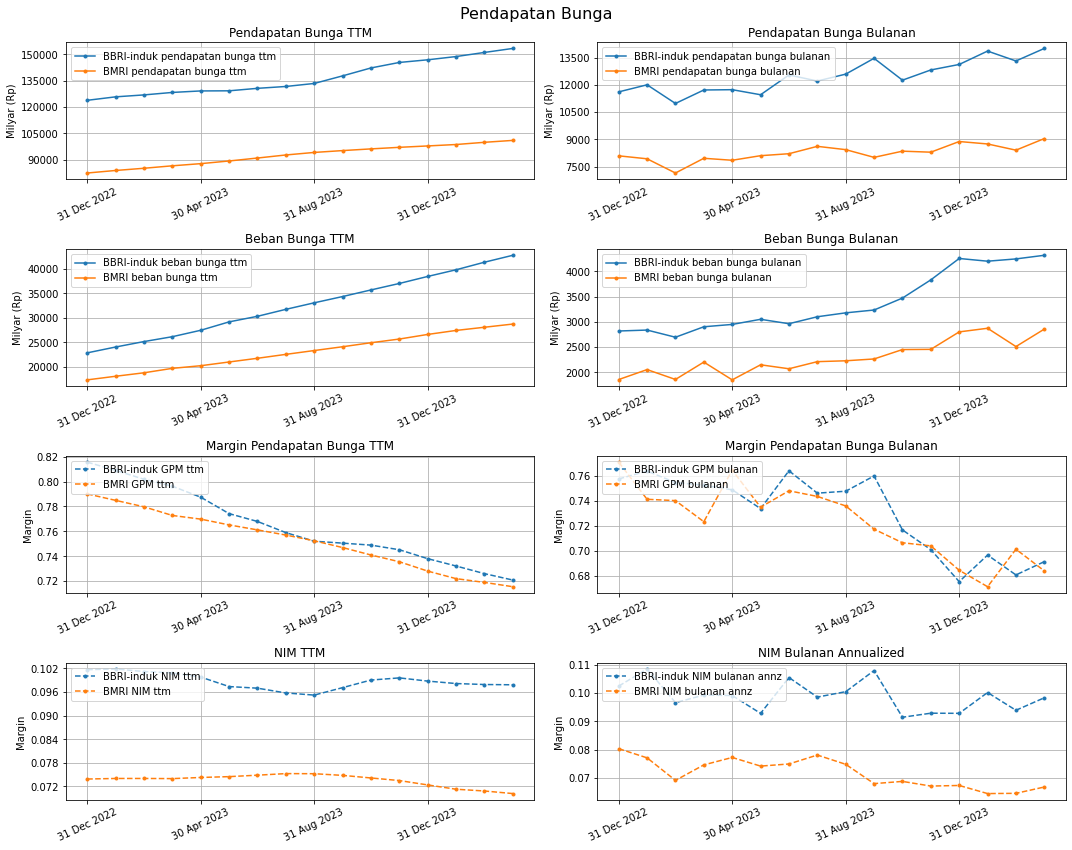

Catatan:
- NIM TTM = (pendapatan bunga TTM minus beban bunga TTM) dibagi rata-rata kredit setahun terakhir
- NIM bulanan annualized = (pendapatan bunga bulanan minus beban bunga bulanan) kali 12 dibagi kredit


#### PPOP

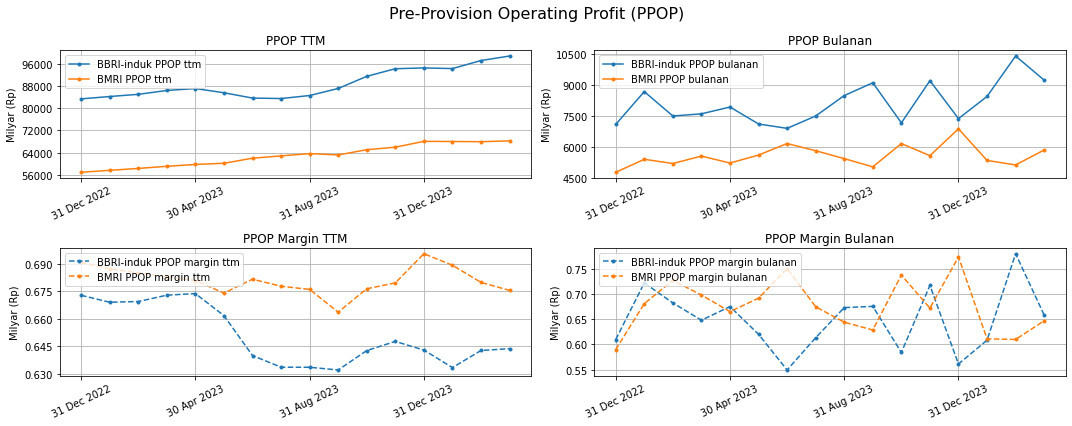

Catatan:
- PPOP = laba operasional ditambah beban impairment
- PPOP margin = PPOP dibagi pendapatan bunga


#### Beban Impairment

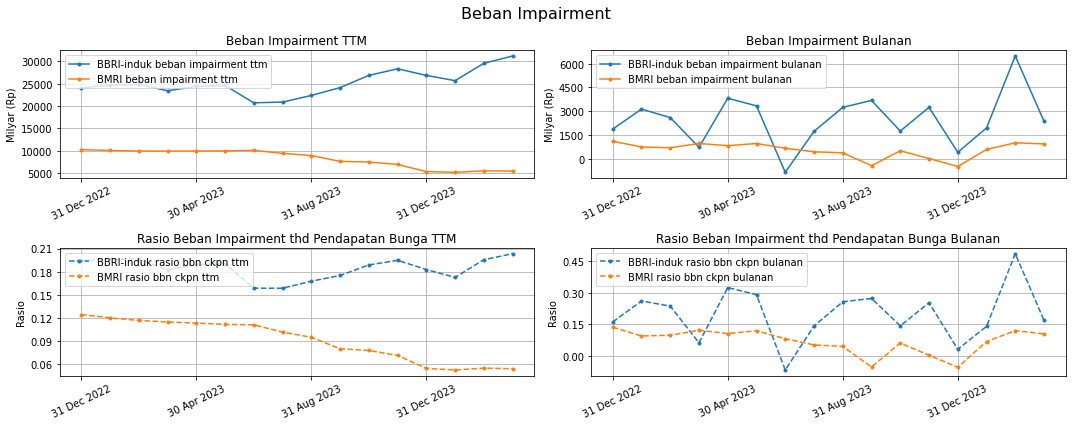

#### Operating Profit

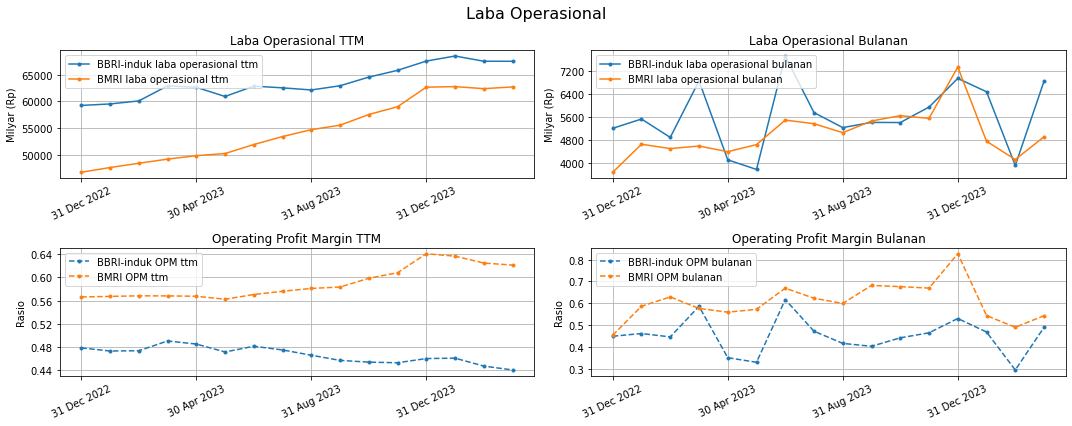

#### Laba Bersih dan NPM

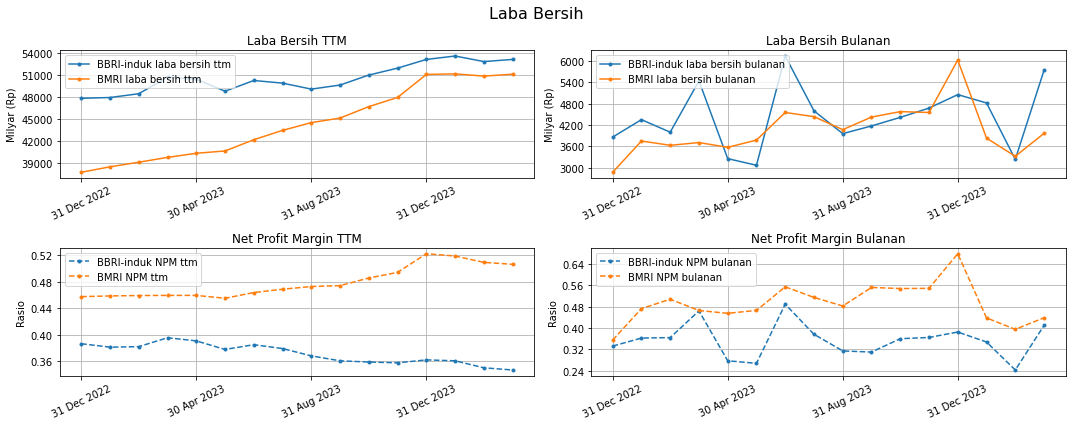

#### Rasio Rasio Lain

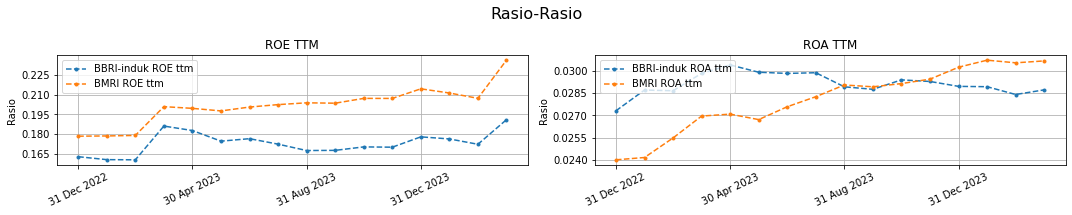

In [16]:
#for ticker_lktype in TICKER_LKTYPES:
#    plot_everything([ticker_lktype], normalize=False)
_ = plot_everything(TICKER_LKTYPES, normalize=False)